# SMS Spam Classifier

## Importing the dependencies

In [291]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the dataset

In [292]:
df = pd.read_csv('spam.csv', encoding='latin-1')

In [293]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
381,ham,"Yeah sure, give me a couple minutes to track d...",NaN,NaN,NaN
2468,ham,Lol well don't do it without me. We could have...,NaN,NaN,NaN
4438,ham,i want to grasp your pretty booty :),NaN,NaN,NaN
2307,spam,WIN a year supply of CDs 4 a store of ur choic...,NaN,NaN,NaN
4497,spam,Latest Nokia Mobile or iPOD MP3 Player +å£400 ...,NaN,NaN,NaN


In [294]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [295]:
df.shape

(5572, 5)

## Data Cleaning

In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [297]:
# drop the last three columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [298]:
df.sample(6)

,v1,v2
1303,ham,I cant pick the phone right now. Pls send a me...
2769,spam,Burger King - Wanna play footy at a top stadiu...
2848,spam,YOUR CHANCE TO BE ON A REALITY FANTASY SHOW ca...
3456,ham,Friendship poem: Dear O Dear U R Not Near But ...
4388,ham,"K I'm ready, &lt;#&gt; ?"
4109,ham,"Yo, you gonna still be in stock tomorrow/today..."


In [299]:
# renaming the columns
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

In [300]:
df.sample(6)

,target,text
1363,ham,"Yetunde, i'm sorry but moji and i seem too bus..."
4074,ham,"God picked up a flower and dippeditinaDEW, lov..."
4205,ham,"Get the door, I'm here"
5230,ham,"Nope, I'm still in the market"
2200,ham,Haha... can... But i'm having dinner with my c...
4538,ham,"Party's at my place at usf, no charge (but if ..."


In [301]:
# Label Encoding
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [302]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [303]:
# check for missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [304]:
# check for duplicate values
df.duplicated().sum()

403

In [305]:
df.drop_duplicates(keep='first', inplace=True)

In [306]:
df.duplicated().sum()

0

## Exploratory Data Analysis

In [307]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

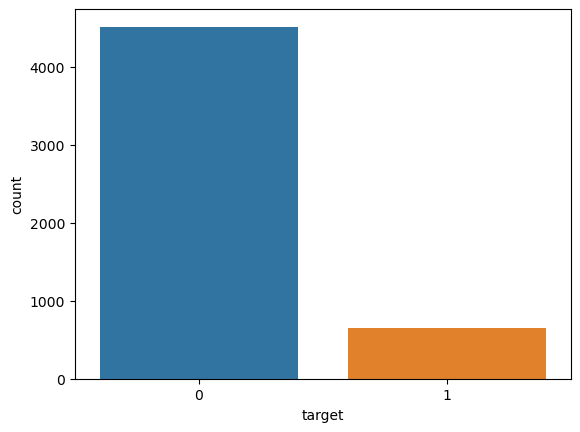

In [308]:
sns.countplot(x='target', data=df)
plt.show()

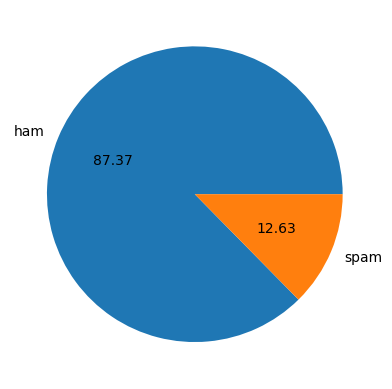

In [309]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')
plt.show()

Class imbalance in data

In [310]:
df['text'].apply(len) # number of characters

0       111
1        29
2       155
3        49
4        61
       ... 
5567    161
5568     37
5569     57
5570    125
5571     26
Name: text, Length: 5169, dtype: int64

In [311]:
df['num_characters'] = df['text'].apply(len)

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   target          5169 non-null   int32 
 1   text            5169 non-null   object
 2   num_characters  5169 non-null   int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 141.3+ KB


In [313]:
# number of words
df['text'].apply(lambda x: nltk.word_tokenize(x))

0       [Go, until, jurong, point, ,, crazy, .., Avail...
1                [Ok, lar, ..., Joking, wif, u, oni, ...]
2       [Free, entry, in, 2, a, wkly, comp, to, win, F...
3       [U, dun, say, so, early, hor, ..., U, c, alrea...
4       [Nah, I, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [This, is, the, 2nd, time, we, have, tried, 2,...
5568     [Will, Ì_, b, going, to, esplanade, fr, home, ?]
5569    [Pity, ,, *, was, in, mood, for, that, ., So, ...
5570    [The, guy, did, some, bitching, but, I, acted,...
5571                  [Rofl, ., Its, true, to, its, name]
Name: text, Length: 5169, dtype: object

In [314]:
df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

0       24
1        8
2       37
3       13
4       15
        ..
5567    35
5568     9
5569    15
5570    27
5571     7
Name: text, Length: 5169, dtype: int64

In [315]:
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [316]:
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [317]:
# number of sentences
df['text'].apply(lambda x: nltk.sent_tokenize(x))

0       [Go until jurong point, crazy.., Available onl...
1                        [Ok lar..., Joking wif u oni...]
2       [Free entry in 2 a wkly comp to win FA Cup fin...
3       [U dun say so early hor... U c already then sa...
4       [Nah I don't think he goes to usf, he lives ar...
                              ...                        
5567    [This is the 2nd time we have tried 2 contact ...
5568              [Will Ì_ b going to esplanade fr home?]
5569    [Pity, * was in mood for that., So...any other...
5570    [The guy did some bitching but I acted like i'...
5571                        [Rofl., Its true to its name]
Name: text, Length: 5169, dtype: object

In [318]:
df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

0       2
1       2
2       2
3       1
4       1
       ..
5567    4
5568    1
5569    2
5570    1
5571    2
Name: text, Length: 5169, dtype: int64

In [319]:
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [320]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [321]:
df.describe()

,target,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.453279,1.947185
std,0.332253,58.236293,13.324793,1.362406
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,28.000000


In [322]:
df[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.453279,1.947185
std,58.236293,13.324793,1.362406
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


In [323]:
# ham
df[df['target'] == 0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [324]:
# spam
df[df['target'] == 1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


C:\Users\anupa\.android\trial\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anupa\.android\trial\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


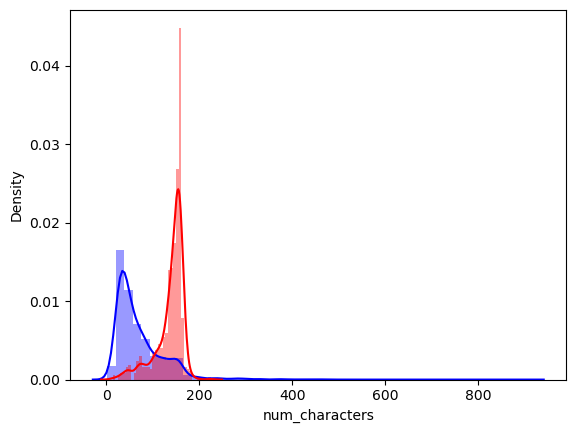

In [325]:
sns.distplot(df[df['target'] == 0]['num_characters'], color='blue')
sns.distplot(df[df['target'] == 1]['num_characters'], color='red')
plt.show()

C:\Users\anupa\.android\trial\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anupa\.android\trial\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


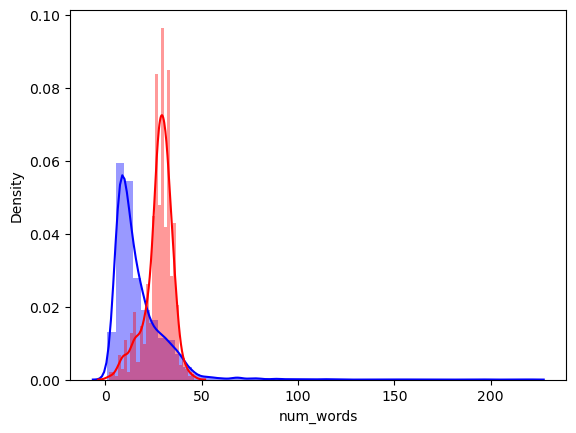

In [326]:
sns.distplot(df[df['target'] == 0]['num_words'], color='blue')
sns.distplot(df[df['target'] == 1]['num_words'], color='red')
plt.show()

C:\Users\anupa\.android\trial\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anupa\.android\trial\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


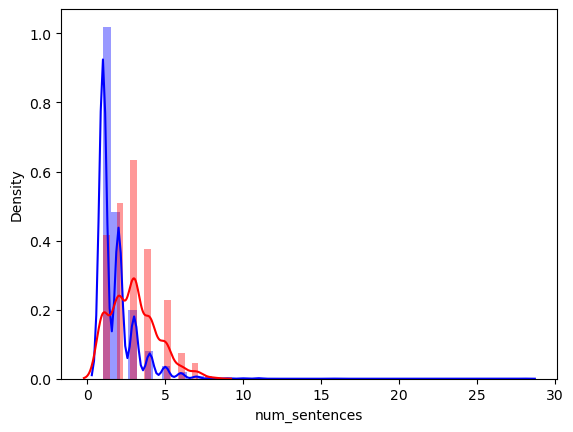

In [327]:
sns.distplot(df[df['target'] == 0]['num_sentences'], color='blue')
sns.distplot(df[df['target'] == 1]['num_sentences'], color='red')
plt.show()

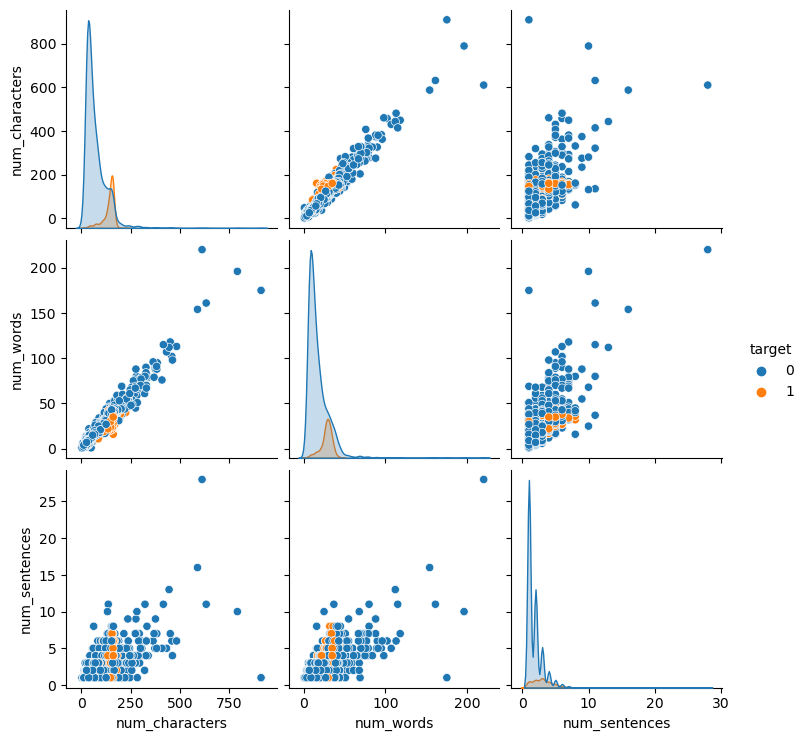

In [328]:
sns.pairplot(df, hue='target')

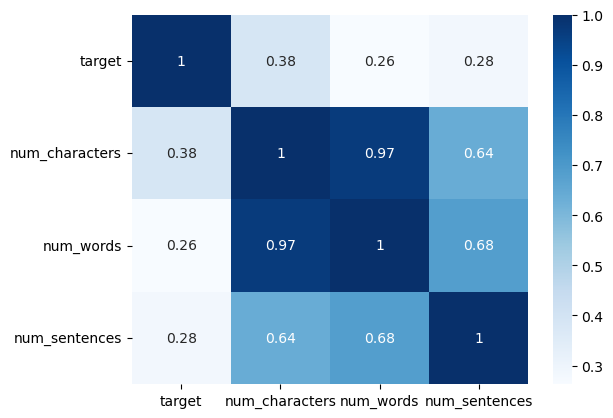

In [329]:
sns.heatmap(df.corr(), cbar=True, annot=True, cmap='Blues')
plt.show()

In [330]:
# Multicollinearity observed in data
# We gonna use num_characters as it has highest correlation (= 0.38) with target

## Data Preprocessing

In [331]:
ps = PorterStemmer()

In [332]:
ps.stem('dancing')

'danc'

In [333]:
def transform_text(text):
    # lower case
    text = text.lower()  
    
    # tokenization
    text = nltk.word_tokenize(text) 
    
    # removing special characters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
            
    # removing stopwords and punctuation
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    
    # stemming
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
        
    return ' '.join(y)

In [334]:
transform_text('Hello Nitish?')

'hello nitish'

In [335]:
df['text'].apply(transform_text)

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkt 21...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
                              ...                        
5567    2nd time tri 2 contact u pound prize 2 claim e...
5568                                b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: text, Length: 5169, dtype: object

In [336]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [337]:
df['transformed_text'] = df['text'].apply(transform_text)

In [338]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [339]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

In [340]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=' '))

In [341]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=' '))

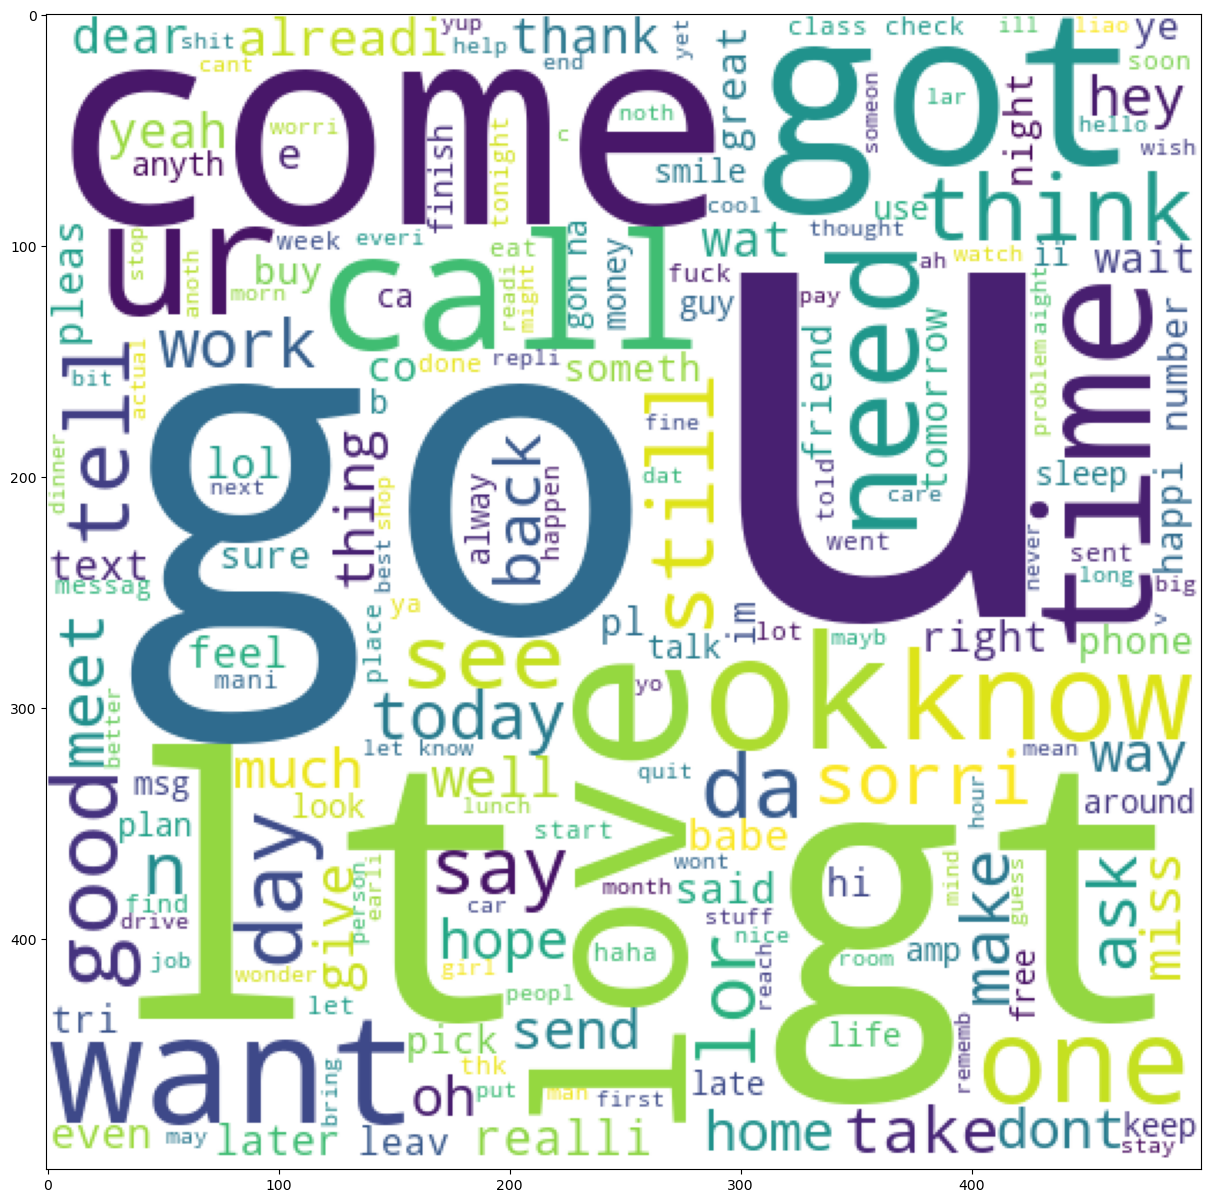

In [342]:
plt.figure(figsize=(20, 15))
plt.imshow(spam_wc)
plt.show()

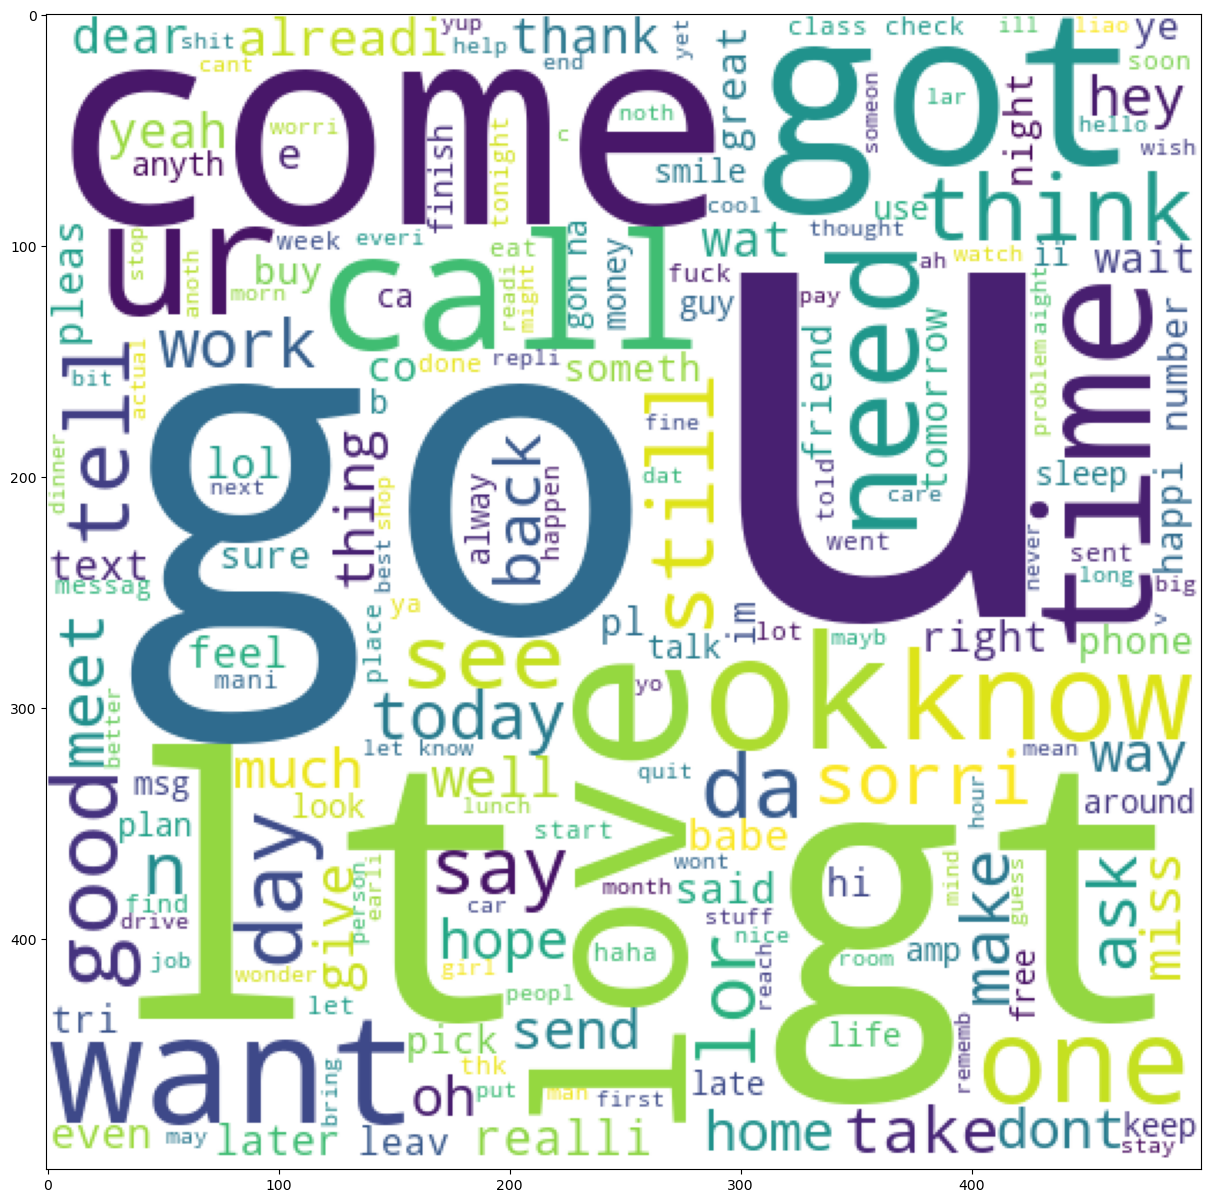

In [343]:
plt.figure(figsize=(20, 15))
plt.imshow(ham_wc)
plt.show()

In [344]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text']:
    for word in msg.split():
        spam_corpus.append(word)

In [345]:
spam_corpus

['free',
 'entri',
 '2',
 'wkli',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkt',
 '21st',
 'may',
 'text',
 'fa',
 '87121',
 'receiv',
 'entri',
 'question',
 'std',
 'txt',
 'rate',
 'c',
 'appli',
 '08452810075over18',
 'freemsg',
 'hey',
 'darl',
 '3',
 'week',
 'word',
 'back',
 'like',
 'fun',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chg',
 'send',
 'rcv',
 'winner',
 'valu',
 'network',
 'custom',
 'select',
 'receivea',
 'prize',
 'reward',
 'claim',
 'call',
 'claim',
 'code',
 'kl341',
 'valid',
 '12',
 'hour',
 'mobil',
 '11',
 'month',
 'u',
 'r',
 'entitl',
 'updat',
 'latest',
 'colour',
 'mobil',
 'camera',
 'free',
 'call',
 'mobil',
 'updat',
 'co',
 'free',
 '08002986030',
 'six',
 'chanc',
 'win',
 'cash',
 '100',
 'pound',
 'txt',
 'csh11',
 'send',
 'cost',
 '6day',
 'tsandc',
 'appli',
 'repli',
 'hl',
 '4',
 'info',
 'urgent',
 '1',
 'week',
 'free',
 'membership',
 'prize',
 'jackpot',
 'txt',
 'word',
 'claim',
 '81010',
 'c',
 'lccltd',
 'pobox',
 '4403ldnw

In [346]:
len(spam_corpus)

9939

In [347]:
from collections import Counter
Counter(spam_corpus)

Counter({'free': 191,
         'entri': 21,
         '2': 155,
         'wkli': 9,
         'comp': 8,
         'win': 48,
         'fa': 2,
         'cup': 3,
         'final': 14,
         'tkt': 2,
         '21st': 1,
         'may': 6,
         'text': 122,
         '87121': 2,
         'receiv': 31,
         'question': 9,
         'std': 6,
         'txt': 141,
         'rate': 26,
         'c': 45,
         'appli': 24,
         '08452810075over18': 1,
         'freemsg': 14,
         'hey': 5,
         'darl': 2,
         '3': 20,
         'week': 49,
         'word': 21,
         'back': 20,
         'like': 12,
         'fun': 8,
         'still': 5,
         'tb': 1,
         'ok': 5,
         'xxx': 10,
         'chg': 2,
         'send': 60,
         'rcv': 2,
         'winner': 13,
         'valu': 8,
         'network': 26,
         'custom': 42,
         'select': 26,
         'receivea': 1,
         'prize': 82,
         'reward': 9,
         'claim': 98,
         'cal

In [348]:
pd.DataFrame(Counter(spam_corpus).most_common(30))

,0,1
0,call,320
1,free,191
2,2,155
3,txt,141
4,text,122
5,u,119
6,ur,119
7,mobil,114
8,stop,104
9,repli,103


C:\Users\anupa\.android\trial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


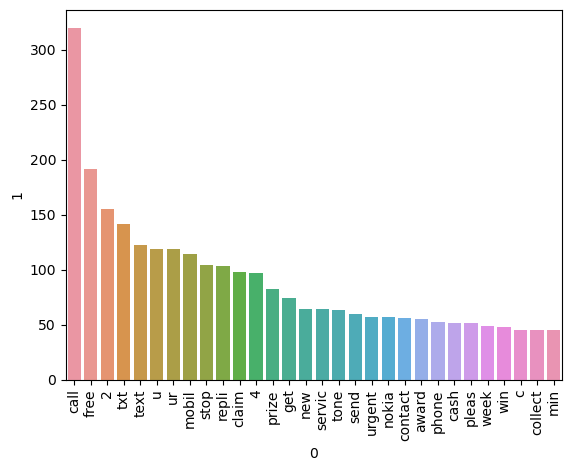

In [349]:
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0], pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [350]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text']:
    for word in msg.split():
        ham_corpus.append(word)

In [351]:
len(ham_corpus)

35394

In [352]:
ham_corpus

['go',
 'jurong',
 'point',
 'crazi',
 'avail',
 'bugi',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amor',
 'wat',
 'ok',
 'lar',
 'joke',
 'wif',
 'u',
 'oni',
 'u',
 'dun',
 'say',
 'earli',
 'hor',
 'u',
 'c',
 'alreadi',
 'say',
 'nah',
 'think',
 'goe',
 'usf',
 'live',
 'around',
 'though',
 'even',
 'brother',
 'like',
 'speak',
 'treat',
 'like',
 'aid',
 'patent',
 'per',
 'request',
 'mell',
 'oru',
 'minnaminungint',
 'nurungu',
 'vettam',
 'set',
 'callertun',
 'caller',
 'press',
 '9',
 'copi',
 'friend',
 'callertun',
 'gon',
 'na',
 'home',
 'soon',
 'want',
 'talk',
 'stuff',
 'anymor',
 'tonight',
 'k',
 'cri',
 'enough',
 'today',
 'search',
 'right',
 'word',
 'thank',
 'breather',
 'promis',
 'wont',
 'take',
 'help',
 'grant',
 'fulfil',
 'promis',
 'wonder',
 'bless',
 'time',
 'date',
 'sunday',
 'oh',
 'k',
 'watch',
 'eh',
 'u',
 'rememb',
 '2',
 'spell',
 'name',
 'ye',
 'v',
 'naughti',
 'make',
 'v',
 'wet',
 'fine',
 'thatåõ',
 'wa

In [353]:
Counter(ham_corpus)

Counter({'go': 404,
         'jurong': 1,
         'point': 17,
         'crazi': 10,
         'avail': 13,
         'bugi': 7,
         'n': 120,
         'great': 97,
         'world': 28,
         'la': 7,
         'e': 77,
         'buffet': 2,
         'cine': 7,
         'got': 236,
         'amor': 1,
         'wat': 108,
         'ok': 217,
         'lar': 38,
         'joke': 14,
         'wif': 27,
         'u': 883,
         'oni': 4,
         'dun': 55,
         'say': 127,
         'earli': 33,
         'hor': 2,
         'c': 57,
         'alreadi': 90,
         'nah': 10,
         'think': 149,
         'goe': 26,
         'usf': 10,
         'live': 25,
         'around': 59,
         'though': 26,
         'even': 77,
         'brother': 17,
         'like': 234,
         'speak': 24,
         'treat': 19,
         'aid': 2,
         'patent': 1,
         'per': 9,
         'request': 6,
         'mell': 1,
         'oru': 2,
         'minnaminungint': 1,
         'nur

In [354]:
pd.DataFrame(Counter(ham_corpus).most_common(30))

,0,1
0,u,883
1,go,404
2,get,349
3,gt,288
4,lt,287
5,2,284
6,come,275
7,got,236
8,know,236
9,like,234


C:\Users\anupa\.android\trial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


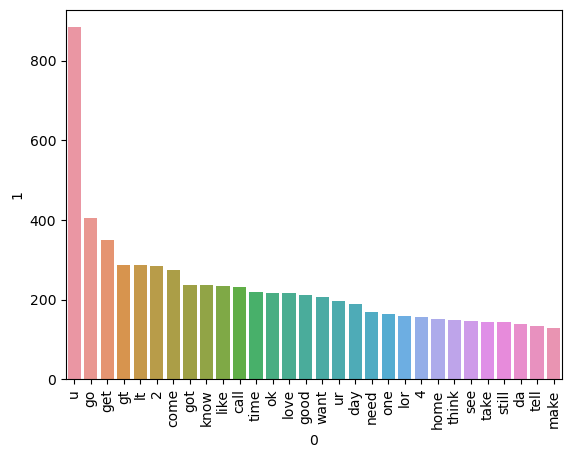

In [355]:
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0], pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

## Model Building

In [356]:
cv = CountVectorizer()

In [357]:
X = cv.fit_transform(df['transformed_text']).toarray()

In [358]:
X.shape

(5169, 6708)

In [359]:
y = df['target']

In [360]:
type(y)

pandas.core.series.Series

In [361]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [362]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [363]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8665377176015474
[[782 121]
 [ 17 114]]
0.4851063829787234


In [364]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.971953578336557
[[884  19]
 [ 10 121]]
0.8642857142857143


In [365]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9777562862669246
[[902   1]
 [ 22 109]]
0.990909090909091


In [366]:
vectorizer = TfidfVectorizer()

In [367]:
X = vectorizer.fit_transform(df['transformed_text']).toarray()

In [368]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [369]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8636363636363636
[[781 122]
 [ 19 112]]
0.47863247863247865


In [370]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9574468085106383
[[903   0]
 [ 44  87]]
1.0


In [371]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9777562862669246
[[902   1]
 [ 22 109]]
0.990909090909091


I am gonna use MultinomialNB with TfidfVectorizer

In [372]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [373]:
svc = SVC(kernel='sigmoid', gamma=1)
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
knc = KNeighborsClassifier()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=0)
abc = AdaBoostClassifier(n_estimators=50, random_state=0)
bc = BaggingClassifier(n_estimators=50, random_state=0)
etc = ExtraTreesClassifier(n_estimators=50, random_state=0)
gbc = GradientBoostingClassifier(n_estimators=50, random_state=0)
xgb = XGBClassifier(n_estimators=50, random_state=0)

In [374]:
clfs = {
    'SVC': svc,
    'KN': knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BGC': bc,
    'ETC': etc,
    'GBC': gbc,
    'XGB': xgb
}

In [375]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    return accuracy, precision

In [376]:
train_classifier(svc, X_train, y_train, X_test, y_test)

(0.97678916827853, 0.9734513274336283)

In [377]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    accuracy, precision = train_classifier(clf, X_train, y_train, X_test, y_test)
    
    print('For ', name)
    print('Accuracy score = ', accuracy)
    print('Precision score = ', precision)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)

For  SVC
Accuracy score =  0.97678916827853
Precision score =  0.9734513274336283


C:\Users\anupa\.android\trial\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


For  KN
Accuracy score =  0.8994197292069632
Precision score =  1.0
For  NB
Accuracy score =  0.9574468085106383
Precision score =  1.0
For  DT
Accuracy score =  0.9361702127659575
Precision score =  0.8282828282828283
For  LR
Accuracy score =  0.9526112185686654
Precision score =  0.9270833333333334
For  RF
Accuracy score =  0.9738878143133463
Precision score =  0.9905660377358491
For  AdaBoost
Accuracy score =  0.9613152804642167
Precision score =  0.941747572815534
For  BGC
Accuracy score =  0.9661508704061895
Precision score =  0.875
For  ETC
Accuracy score =  0.9748549323017408
Precision score =  0.9646017699115044
For  GBC
Accuracy score =  0.9516441005802708
Precision score =  0.9354838709677419
For  XGB
Accuracy score =  0.9738878143133463
Precision score =  0.940677966101695


In [378]:
clfs.keys()

dict_keys(['SVC', 'KN', 'NB', 'DT', 'LR', 'RF', 'AdaBoost', 'BGC', 'ETC', 'GBC', 'XGB'])

In [379]:
performance_df = pd.DataFrame({'Algorithm': clfs.keys(), 'Accuracy Score': accuracy_scores, 'Precision Score': precision_scores})

In [380]:
performance_df

,Algorithm,Accuracy Score,Precision Score
0,SVC,0.976789,0.973451
1,KN,0.899420,1.000000
2,NB,0.957447,1.000000
3,DT,0.936170,0.828283
4,LR,0.952611,0.927083
5,RF,0.973888,0.990566
6,AdaBoost,0.961315,0.941748
7,BGC,0.966151,0.875000
8,ETC,0.974855,0.964602
9,GBC,0.951644,0.935484


In [381]:
performance_df.sort_values('Precision Score', ascending=False)

,Algorithm,Accuracy Score,Precision Score
1,KN,0.899420,1.000000
2,NB,0.957447,1.000000
5,RF,0.973888,0.990566
0,SVC,0.976789,0.973451
8,ETC,0.974855,0.964602
6,AdaBoost,0.961315,0.941748
10,XGB,0.973888,0.940678
9,GBC,0.951644,0.935484
4,LR,0.952611,0.927083
7,BGC,0.966151,0.875000


In [382]:
# model improvement
# 1. Change the max_features parameter of TfidfVectorizer

In [383]:
vectorizer = TfidfVectorizer(max_features=3000)

In [384]:
X = vectorizer.fit_transform(df['transformed_text']).toarray()

In [385]:
X.shape

(5169, 3000)

In [386]:
y = df['target']

In [387]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [388]:
train_classifier(mnb, X_train, y_train, X_test, y_test)

(0.971953578336557, 0.9903846153846154)

In [389]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    accuracy, precision = train_classifier(clf, X_train, y_train, X_test, y_test)
    
    print('For ', name)
    print('Accuracy score = ', accuracy)
    print('Precision score = ', precision)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)

For  SVC
Accuracy score =  0.9806576402321083
Precision score =  0.9743589743589743


C:\Users\anupa\.android\trial\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


For  KN
Accuracy score =  0.90715667311412
Precision score =  1.0
For  NB
Accuracy score =  0.971953578336557
Precision score =  0.9903846153846154
For  DT
Accuracy score =  0.9352030947775629
Precision score =  0.826530612244898
For  LR
Accuracy score =  0.9555125725338491
Precision score =  0.9381443298969072
For  RF
Accuracy score =  0.97678916827853
Precision score =  0.9908256880733946
For  AdaBoost
Accuracy score =  0.9632495164410058
Precision score =  0.9428571428571428
For  BGC
Accuracy score =  0.965183752417795
Precision score =  0.8518518518518519
For  ETC
Accuracy score =  0.971953578336557
Precision score =  0.925
For  GBC
Accuracy score =  0.9564796905222437
Precision score =  0.9574468085106383
For  XGB
Accuracy score =  0.9748549323017408
Precision score =  0.972972972972973


In [390]:
performance_df_3000 = pd.DataFrame({'Algorithm': clfs.keys(), 'Accuracy Score (3000)': accuracy_scores, 'Precision Score (3000)': precision_scores})

In [391]:
performance_df = performance_df.merge(performance_df_3000, on='Algorithm')

In [392]:
performance_df

,Algorithm,Accuracy Score,Precision Score,Accuracy Score (3000),Precision Score (3000)
0,SVC,0.976789,0.973451,0.980658,0.974359
1,KN,0.899420,1.000000,0.907157,1.000000
2,NB,0.957447,1.000000,0.971954,0.990385
3,DT,0.936170,0.828283,0.935203,0.826531
4,LR,0.952611,0.927083,0.955513,0.938144
5,RF,0.973888,0.990566,0.976789,0.990826
6,AdaBoost,0.961315,0.941748,0.963250,0.942857
7,BGC,0.966151,0.875000,0.965184,0.851852
8,ETC,0.974855,0.964602,0.971954,0.925000
9,GBC,0.951644,0.935484,0.956480,0.957447


In [393]:
X = vectorizer.fit_transform(df['transformed_text']).toarray()

In [394]:
X = np.hstack((X, df['num_characters'].values.reshape(-1, 1)))

In [395]:
X.shape

(5169, 3001)

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [397]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    accuracy, precision = train_classifier(clf, X_train, y_train, X_test, y_test)
    
    print('For ', name)
    print('Accuracy score = ', accuracy)
    print('Precision score = ', precision)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)

C:\Users\anupa\.android\trial\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For  SVC
Accuracy score =  0.8733075435203095
Precision score =  0.0


C:\Users\anupa\.android\trial\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


For  KN
Accuracy score =  0.9477756286266924
Precision score =  0.8598130841121495
For  NB
Accuracy score =  0.9284332688588007
Precision score =  0.9830508474576272
For  DT
Accuracy score =  0.9448742746615088
Precision score =  0.8854166666666666
For  LR
Accuracy score =  0.9622823984526112
Precision score =  0.96
For  RF
Accuracy score =  0.9777562862669246
Precision score =  0.9576271186440678
For  AdaBoost
Accuracy score =  0.971953578336557
Precision score =  0.9322033898305084
For  BGC
Accuracy score =  0.9622823984526112
Precision score =  0.8833333333333333
For  ETC
Accuracy score =  0.9738878143133463
Precision score =  0.9482758620689655
For  GBC
Accuracy score =  0.9506769825918762
Precision score =  0.9081632653061225
For  XGB
Accuracy score =  0.9748549323017408
Precision score =  0.9411764705882353


In [398]:
temp_df = pd.DataFrame({'Algorithm': clfs.keys(), 'Accuracy Score': accuracy_scores, 'Precision Score': precision_scores})

In [399]:
performance_df = performance_df.merge(temp_df, on='Algorithm')

In [400]:
performance_df

,Algorithm,Accuracy Score_x,Precision Score_x,Accuracy Score (3000),Precision Score (3000),Accuracy Score_y,Precision Score_y
0,SVC,0.976789,0.973451,0.980658,0.974359,0.873308,0.000000
1,KN,0.899420,1.000000,0.907157,1.000000,0.947776,0.859813
2,NB,0.957447,1.000000,0.971954,0.990385,0.928433,0.983051
3,DT,0.936170,0.828283,0.935203,0.826531,0.944874,0.885417
4,LR,0.952611,0.927083,0.955513,0.938144,0.962282,0.960000
5,RF,0.973888,0.990566,0.976789,0.990826,0.977756,0.957627
6,AdaBoost,0.961315,0.941748,0.963250,0.942857,0.971954,0.932203
7,BGC,0.966151,0.875000,0.965184,0.851852,0.962282,0.883333
8,ETC,0.974855,0.964602,0.971954,0.925000,0.973888,0.948276
9,GBC,0.951644,0.935484,0.956480,0.957447,0.950677,0.908163


In [401]:
# So, I am gonna go with RandomForestClassifier model

In [402]:
vectorizer = TfidfVectorizer(max_features=3000)

In [403]:
X = vectorizer.fit_transform(df['transformed_text']).toarray()

In [404]:
y = df['target']

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [406]:
# Voting classifier
svc = SVC(kernel='sigmoid', gamma=1.0, probability=True)
mnb = MultinomialNB()
rfc = ExtraTreesClassifier(n_estimators=50, random_state=0)

from sklearn.ensemble import VotingClassifier

In [407]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)], voting='soft')

In [408]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=0))],
                 voting='soft')

In [409]:
y_pred_voting = voting.predict(X_test)

In [410]:
print(accuracy_score(y_test, y_pred_voting))
print(confusion_matrix(y_test, y_pred_voting))
print(precision_score(y_test, y_pred_voting))

0.9825918762088974
[[900   3]
 [ 15 116]]
0.9747899159663865


In [411]:
# apply stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator = RandomForestClassifier()

In [412]:
from sklearn.ensemble import StackingClassifier

In [413]:
model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [414]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('svm',
                                SVC(gamma=1.0, kernel='sigmoid',
                                    probability=True)),
                               ('nb', MultinomialNB()),
                               ('et',
                                ExtraTreesClassifier(n_estimators=50,
                                                     random_state=0))],
                   final_estimator=RandomForestClassifier())

In [415]:
y_pred_stacking = model.predict(X_test)
print(accuracy_score(y_test, y_pred_stacking))
print(confusion_matrix(y_test, y_pred_stacking))
print(precision_score(y_test, y_pred_stacking))

0.9816247582205029
[[896   7]
 [ 12 119]]
0.9444444444444444


In [418]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [419]:
import pickle
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))